In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data as data_utils


In [2]:
!pip install yfinance

In [3]:

import pandas as pd
import numpy as np
import os.path
from functools import reduce

import datetime, time, os, requests, torch
import yfinance as yf
from bs4 import BeautifulSoup as BS

import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Using cpu device


In [5]:

import os
import warnings
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import requests
from urllib3.exceptions import InsecureRequestWarning

# Suppress only the single InsecureRequestWarning from urllib3
warnings.filterwarnings('ignore', category=InsecureRequestWarning)


class MyDataset:
    def __init__(self,
                 url='https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',
                 stocks_fname='sp500_closes.csv',
                 verify_ssl=True):
        """
        Initialize dataset loader for S&P 500 stocks.

        Args:
            url: Wikipedia URL for S&P 500 constituents
            stocks_fname: Filename for cached stock data
            verify_ssl: Whether to verify SSL certificates (default: True)
                       Set to False if behind corporate proxy with SSL inspection
        """
        self.url = url
        self.stocks_fname = stocks_fname
        self.verify_ssl = verify_ssl

        if not verify_ssl:
            warnings.warn(
                "SSL verification is disabled. This is not recommended for production use. "
                "Only use this option if you're behind a corporate proxy.",
                UserWarning
            )

    def _get_sp500_tickers(self):
        """
        Fetch S&P 500 ticker symbols from Wikipedia with robust error handling.

        Returns:
            list: List of ticker symbols
        """
        print("➡️ Fetching S&P 500 tickers...")
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                          '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        max_retries = 3
        retry_delay = 2

        for attempt in range(max_retries):
            try:
                resp = requests.get(
                    self.url,
                    headers=headers,
                    timeout=30,
                    verify=self.verify_ssl
                )
                resp.raise_for_status()

                # Parse HTML tables
                tables = pd.read_html(resp.text, attrs={'id': 'constituents'})
                if not tables:
                    raise ValueError("No table found with id='constituents'")

                df = tables[0]
                tickers = df['Symbol'].str.replace('.', '-', regex=False).tolist()

                print(f"✅ Successfully fetched {len(tickers)} tickers")
                return tickers

            except requests.exceptions.SSLError as e:
                if attempt < max_retries - 1:
                    print(f"⚠️ SSL Error on attempt {attempt + 1}/{max_retries}. Retrying...")
                    import time
                    time.sleep(retry_delay * (attempt + 1))
                else:
                    print("❌ SSL verification failed after all retries.")
                    print("💡 Solution: Initialize with MyDataset(verify_ssl=False) if behind a corporate proxy")
                    raise

            except requests.exceptions.RequestException as e:
                if attempt < max_retries - 1:
                    print(f"⚠️ Request failed on attempt {attempt + 1}/{max_retries}. Retrying...")
                    import time
                    time.sleep(retry_delay * (attempt + 1))
                else:
                    print(f"❌ Failed to fetch tickers after {max_retries} attempts: {e}")
                    raise

    def get_train_test(self, top_k_features=50):
        """
        Load or download S&P 500 data and split into train/test/validation sets.

        Args:
            top_k_features: Number of top features to select

        Returns:
            tuple: (train_labels, train_features, test_labels, test_features,
                   val_labels, val_features)
        """
        # Define date ranges
        end = datetime.now()
        start = end - timedelta(days=5 * 365)  # 5 years of data

        # 1) Download or load cached closes (wide: columns=tickers)
        if not os.path.isfile(self.stocks_fname):
            tickers = self._get_sp500_tickers()
            print("➡️ Downloading all S&P 500 stocks (auto_adjust=True)...")
            data = yf.download(
                tickers, start=start, end=end,
                auto_adjust=True, group_by='ticker',
                progress=True, threads=True
            )

            # Extract closing prices
            if isinstance(data.columns, pd.MultiIndex):
                closes = data.xs('Close', level=1, axis=1)
            else:
                closes = data['Close'] if 'Close' in data.columns else data

            closes.to_csv(self.stocks_fname)
            print(f"✅ Saved to {self.stocks_fname}")
        else:
            print(f"➡️ Loading cached data from {self.stocks_fname}")
            closes = pd.read_csv(self.stocks_fname, index_col=0, parse_dates=True)

        # 2) Drop tickers with too many NaNs
        threshold = len(closes) * 0.8
        closes = closes.dropna(thresh=threshold, axis=1)
        closes = closes.fillna(method='ffill').fillna(method='bfill')

        print(f"📊 Data shape: {closes.shape}")

        # 3) Create binary labels (1 if next day's return > 0, else 0)
        returns = closes.pct_change().shift(-1)  # Next day's return
        labels = (returns > 0).astype(int)
        labels = labels.iloc[:-1]  # Remove last row (no future return)

        # 4) Create features (percent changes)
        features = closes.pct_change().iloc[:-1]  # Remove last row to match labels

        # 5) Align and drop any remaining NaNs
        valid_idx = ~(labels.isna().any(axis=1) | features.isna().any(axis=1))
        labels = labels[valid_idx]
        features = features[valid_idx]

        print(f"📊 Valid samples: {len(labels)}")

        # 6) Feature selection (top k by variance)
        if top_k_features and top_k_features < features.shape[1]:
            variances = features.var()
            top_cols = variances.nlargest(top_k_features).index
            features = features[top_cols]
            print(f"📊 Selected top {top_k_features} features by variance")

        # 7) Split into train (60%), validation (20%), test (20%)
        n = len(labels)
        train_size = int(0.6 * n)
        val_size = int(0.2 * n)

        train_labels = labels.iloc[:train_size].values
        train_features = features.iloc[:train_size].values

        val_labels = labels.iloc[train_size:train_size + val_size].values
        val_features = features.iloc[train_size:train_size + val_size].values

        test_labels = labels.iloc[train_size + val_size:].values
        test_features = features.iloc[train_size + val_size:].values

        print(f"✅ Train: {len(train_labels)}, Val: {len(val_labels)}, Test: {len(test_labels)}")

        return train_labels, train_features, test_labels, test_features, val_labels, val_features


# Initialize dataset with SSL verification disabled (if behind corporate proxy)
# For normal environments, use: dataset = MyDataset()
dataset = MyDataset(verify_ssl=False)
train_labels, train_features, test_labels, test_features, val_labels, val_features = dataset.get_train_test()

➡️ Fetching S&P 500 tickers...
✅ Successfully fetched 503 tickers
➡️ Downloading all S&P 500 stocks (auto_adjust=True)...


[**********************66%*******                ]  333 of 503 completedFailed to get ticker 'NUE' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[**********************71%*********              ]  359 of 503 completedFailed to get ticker 'ROK' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[**********************74%***********            ]  370 of 503 completedFailed to get ticker 'AKAM' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[**********************77%************           ]  385 of 503 completedFailed to get ticker 'A' reason: Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-error

✅ Saved to sp500_closes.csv
📊 Data shape: (1254, 482)
📊 Valid samples: 1252
📊 Selected top 50 features by variance
✅ Train: 751, Val: 250, Test: 251


In [7]:
dataset = MyDataset()
train_labels, train_features, test_labels, test_features, val_labels, val_features = dataset.get_train_test()

➡️ Fetching S&P 500 tickers...


SSLError: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_S%26P_500_companies (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:992)')))

In [6]:
train_labels.shape, train_labels.shape, val_labels.shape, val_features.shape

((751, 482), (751, 482), (250, 482), (250, 50))

In [7]:
pd.Series(train_labels.squeeze(1).numpy()).value_counts()

ValueError: cannot select an axis to squeeze out which has size not equal to one

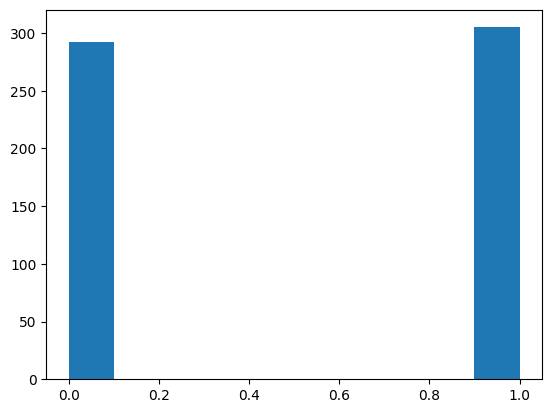

In [ ]:
plt.hist(test_labels.squeeze(1).numpy());

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 16

# --- create datasets ---
train_data = TensorDataset(train_features, train_labels)
val_data   = TensorDataset(val_features,   val_labels)
test_data  = TensorDataset(test_features,  test_labels)  # <-- тут была опечатка!

# --- create loaders ---
# ❗ for time-series classification we usually DO NOT shuffle validation/test
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

# quick sanity check
for X, y in train_dataloader:
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
    break


Shape of X: torch.Size([16, 100])
Shape of y: torch.Size([16, 1])


In [ ]:
import torch
import torch.nn as nn

# Parameterize input dim so it matches your feature matrix
class NeuralNetwork(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)     # logits for BCEWithLogitsLoss
        )
    def forward(self, x):
        return self.net(x)       # returns logits (no sigmoid here)

def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss, n = 0.0, 0
    for X, y in dataloader:
        X = X.to(device, dtype=torch.float32)
        # Ensure labels are float (0/1) and shape (N,1)
        y = y.to(device).float().view(-1, 1)

        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        # (optional) gradient clipping for stability
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        bs = X.size(0)
        total_loss += loss.item() * bs
        n += bs
    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    total_loss, n = 0.0, 0
    correct = 0
    for X, y in dataloader:
        X = X.to(device, dtype=torch.float32)
        y = y.to(device).float().view(-1, 1)

        logits = model(X)
        loss = loss_fn(logits, y)

        # Convert logits to probabilities, then to 0/1
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct += (preds.eq(y)).sum().item()

        bs = X.size(0)
        total_loss += loss.item() * bs
        n += bs
    avg_loss = total_loss / max(n, 1)
    acc = correct / max(n, 1)
    return avg_loss, acc

# ---- wiring ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d_in = X.data.shape[1]  # set to your feature dimension (X.shape[1])

model = NeuralNetwork(d_in).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# (optional) scheduler per-epoch, not per-batch
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

epochs = 10
best_val_acc, best_state = 0.0, None
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(val_dataloader, model, loss_fn, device)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.3f}")
    if val_acc > best_val_acc:
        best_val_acc, best_state = val_acc, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    scheduler.step()

# Restore best on val
if best_state:
    model.load_state_dict(best_state)

# Final test
test_loss, test_acc = evaluate(test_dataloader, model, loss_fn, device)
print(f"Test: loss={test_loss:.4f} | acc={test_acc:.3f}")


Epoch 01 | train_loss=0.6926 | val_loss=0.6824 | val_acc=0.567
Epoch 02 | train_loss=0.6813 | val_loss=0.7008 | val_acc=0.552
Epoch 03 | train_loss=0.6765 | val_loss=0.7074 | val_acc=0.498
Epoch 04 | train_loss=0.6653 | val_loss=0.7022 | val_acc=0.518
Epoch 05 | train_loss=0.6480 | val_loss=0.7225 | val_acc=0.508
Epoch 06 | train_loss=0.6353 | val_loss=0.7314 | val_acc=0.540
Epoch 07 | train_loss=0.6209 | val_loss=0.7535 | val_acc=0.545
Epoch 08 | train_loss=0.6055 | val_loss=0.7772 | val_acc=0.503
Epoch 09 | train_loss=0.5833 | val_loss=0.7980 | val_acc=0.513
Epoch 10 | train_loss=0.5547 | val_loss=0.8126 | val_acc=0.532
Test: loss=0.7034 | acc=0.511


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

@torch.no_grad()
def eval_metrics(model, dl, threshold):
    model.eval()
    probs, ys = [], []
    for X, y in dl:
        p = torch.sigmoid(model(X.to(device))).cpu().numpy().ravel()
        probs.append(p); ys.append(y.cpu().numpy().ravel())
    probs = np.concatenate(probs); ys = np.concatenate(ys)
    preds = (probs > threshold).astype(int)
    print("acc:", accuracy_score(ys, preds))
    print("bal_acc:", balanced_accuracy_score(ys, preds))
    try:
        print("roc_auc:", roc_auc_score(ys, probs))
    except ValueError:
        pass
    print("confusion:\n", confusion_matrix(ys, preds))


In [ ]:
eval_metrics(model, test_dataloader, 0.5)

acc: 0.5108877721943048
bal_acc: 0.500364922524141
roc_auc: 0.4614866382214238
confusion:
 [[  5 287]
 [  5 300]]
